# <b>NYC Motor Vehicle Collisions</b>


## Import Libraries and Data

### Libraries

In [1]:
# Data libraries
import pandas as pd
import numpy as np
import datetime

# Regex
import re

# Maps
from mpl_toolkits.basemap import Basemap

# Plot libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
mpl.rc('font',family='Open Sans') # change the font of the plot

import seaborn as sns
% matplotlib inline

### Data: Collisions
The data is collected from:
https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95

In [2]:
df_collision = pd.read_csv('Collisions.csv',low_memory=False)
df_collision.rename({'VEHICLE_TYPE_CODE1':'VEHICLE_TYPE_CODE_1', 
                     'VEHICLE_TYPE_CODE2':'VEHICLE_TYPE_CODE_2'}, axis='columns',inplace=True)
df_collision.head(2)

,BOROUGH,CONTRIBUTING_FACTOR_VEHICLE_1,CONTRIBUTING_FACTOR_VEHICLE_2,CONTRIBUTING_FACTOR_VEHICLE_3,CONTRIBUTING_FACTOR_VEHICLE_4,CONTRIBUTING_FACTOR_VEHICLE_5,CROSS_STREET_NAME,DATE,LATITUDE,LOCATION,...,OFF_STREET_NAME,ON_STREET_NAME,TIME,UNIQUE_KEY,VEHICLE_TYPE_CODE_1,VEHICLE_TYPE_CODE_2,VEHICLE_TYPE_CODE_3,VEHICLE_TYPE_CODE_4,VEHICLE_TYPE_CODE_5,ZIP_CODE
0,QUEENS,Unspecified,NaN,NaN,NaN,NaN,1 RAILROAD PLACE,2017-03-20T00:00:00.000,40.723854,"{'type': 'Point', 'coordinates': [-73.917305, ...",...,NaN,NaN,8:53,3635593,NaN,NaN,NaN,NaN,NaN,11378
1,BRONX,Obstruction/Debris,NaN,NaN,NaN,NaN,NaN,2017-03-20T00:00:00.000,40.832280,"{'type': 'Point', 'coordinates': [-73.871315, ...",...,CROES AVENUE,EAST 172 STREET,10:30,3635591,NaN,NaN,NaN,NaN,NaN,10472


Let us have a brief look at the data

In [3]:
df_collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084252 entries, 0 to 1084251
Data columns (total 29 columns):
BOROUGH                          771871 non-null object
CONTRIBUTING_FACTOR_VEHICLE_1    1078872 non-null object
CONTRIBUTING_FACTOR_VEHICLE_2    934895 non-null object
CONTRIBUTING_FACTOR_VEHICLE_3    70222 non-null object
CONTRIBUTING_FACTOR_VEHICLE_4    15198 non-null object
CONTRIBUTING_FACTOR_VEHICLE_5    3742 non-null object
CROSS_STREET_NAME                180004 non-null object
DATE                             1084252 non-null object
LATITUDE                         885923 non-null float64
LOCATION                         885923 non-null object
LONGITUDE                        885923 non-null float64
NUMBER_OF_CYCLIST_INJURED        1084252 non-null int64
NUMBER_OF_CYCLIST_KILLED         1084252 non-null int64
NUMBER_OF_MOTORIST_INJURED       1084252 non-null int64
NUMBER_OF_MOTORIST_KILLED        1084252 non-null int64
NUMBER_OF_PEDESTRIANS_INJURED    1084252 non-nu

First, notice that some of the location features are missing. In fact we can compute the number of entries which have no information about the location:

In [4]:
location_features = ['BOROUGH', 'ZIP_CODE', 'LATITUDE','LONGITUDE','LOCATION']
no_location = df_collision[location_features].isnull().all(1).sum()
print('Proportion of data with no location information: ', no_location/len(df_collision)*100,'%')

Proportion of data with no location information:  15.2175877932 %


So about 15% of the data have location information missing.

Let us clean the *df_collision* data frame up a bit. Firstly, let us change the <b>DATE</b> and <b>TIME</b> columns into a proper datetime object:

In [5]:
def to_date(date):
    '''
    Change a string "month-day-year" into a datetime object
    '''
    return datetime.datetime.strptime(date,'%Y-%m-%d')

def to_time(time):
    '''
    Change a string "hour:minute" into a datetime object
    '''
    return datetime.datetime.strptime(time,'%H:%M').time();

try:
    df_collision['DATE'] = df_collision['DATE'].apply(lambda x: x[:10])
    df_collision['DATE'] = df_collision['DATE'].apply(to_date)
except:
    None
try:
    df_collision['TIME'] = df_collision['TIME'].apply(to_time)
except:
    None

In [6]:
df_collision.dtypes

BOROUGH                                  object
CONTRIBUTING_FACTOR_VEHICLE_1            object
CONTRIBUTING_FACTOR_VEHICLE_2            object
CONTRIBUTING_FACTOR_VEHICLE_3            object
CONTRIBUTING_FACTOR_VEHICLE_4            object
CONTRIBUTING_FACTOR_VEHICLE_5            object
CROSS_STREET_NAME                        object
DATE                             datetime64[ns]
LATITUDE                                float64
LOCATION                                 object
LONGITUDE                               float64
NUMBER_OF_CYCLIST_INJURED                 int64
NUMBER_OF_CYCLIST_KILLED                  int64
NUMBER_OF_MOTORIST_INJURED                int64
NUMBER_OF_MOTORIST_KILLED                 int64
NUMBER_OF_PEDESTRIANS_INJURED             int64
NUMBER_OF_PEDESTRIANS_KILLED              int64
NUMBER_OF_PERSONS_INJURED                 int64
NUMBER_OF_PERSONS_KILLED                  int64
OFF_STREET_NAME                          object
ON_STREET_NAME                          

In [7]:
df_collision['DATE'].dtype

dtype('<M8[ns]')

Let us then change the <b>ZIP_CODE</b> into integers and assign missing values to -1

In [8]:
if df_collision['ZIP_CODE'].dtype == 'O':
    # find the missing zip code
    null_zip = (df_collision['ZIP_CODE'].isnull())|(df_collision['ZIP_CODE'].str.strip()=='')
    # assign missing zip code to -1
    df_collision['ZIP_CODE'] = np.where(null_zip ,-1,df_collision['ZIP_CODE'].str.strip())
    # convert to int
    df_collision['ZIP_CODE'] = df_collision['ZIP_CODE'].astype(int)

Finally, let's remove: 
   >- <b>LOCATION</b> attribute since it is redundant (if LATITUDE and LONGITUDE is missing than so is the LOCATION feature so it can't be used to complete the data).
   
   >- <b>UNIQUE KEY</b> since it is not clear what it refers to

In [9]:
if 'LOCATION' in df_collision.columns:
    del df_collision['LOCATION']

if 'UNIQUE_KEY' in df_collision.columns:
    del df_collision['UNIQUE_KEY']
    

Let us finally store the number of entries into a variable N_collision

In [10]:
N_collision = len(df_collision)
print("Number of collisions reported: ", N_collision)

Number of collisions reported:  1084252


### Data: Traffic Volume
The data is collected from:
https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts-2012-2013-/p424-amsu

In [11]:
df_traffic = pd.read_csv('Traffic_Volume.csv')
df_traffic.head(2)

,_10_00_11_00AM,_10_00_11_00PM,_11_00_12_00AM,_11_00_12_00PM,_12_00_1_00_AM,_12_00_1_00PM,_1_00_2_00AM,_1_00_2_00PM,_2_00_3_00AM,_2_00_3_00PM,...,DATE,DIRECTION,FROM,ID,ROADWAY_NAME,SEGMENT_ID,TO,LATITUDE,LONGITUDE,BOROUGH
0,387.0,187.0,169.0,335.0,106.0,406.0,74.0,411.0,45.0,371.0,...,2013-02-02T00:00:00.000,NB,WOODROW RD,1.0,HUGUENOT AVE,2153.0,STAFFORD AVE,40.542882,-74.197147,STATEN ISLAND
1,249.0,125.0,79.0,351.0,109.0,374.0,74.0,350.0,55.0,308.0,...,2013-02-03T00:00:00.000,NB,WOODROW RD,1.0,HUGUENOT AVE,2153.0,STAFFORD AVE,40.542882,-74.197147,STATEN ISLAND


In [12]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 34 columns):
_10_00_11_00AM    5945 non-null float64
_10_00_11_00PM    5945 non-null float64
_11_00_12_00AM    5945 non-null float64
_11_00_12_00PM    5945 non-null float64
_12_00_1_00_AM    5945 non-null float64
_12_00_1_00PM     5945 non-null float64
_1_00_2_00AM      5945 non-null float64
_1_00_2_00PM      5945 non-null float64
_2_00_3_00AM      5945 non-null float64
_2_00_3_00PM      5945 non-null float64
_3_00_4_00AM      5945 non-null float64
_3_00_4_00PM      5945 non-null float64
_4_00_5_00AM      5945 non-null float64
_4_00_5_00PM      5945 non-null float64
_5_00_6_00AM      5945 non-null float64
_5_00_6_00PM      5945 non-null float64
_6_00_7_00AM      5945 non-null float64
_6_00_7_00PM      5945 non-null float64
_7_00_8_00AM      5945 non-null float64
_7_00_8_00PM      5945 non-null float64
_8_00_9_00AM      5945 non-null float64
_8_00_9_00PM      5945 non-null float64
_9_00_10_00AM

Notice that some borough are missing

<b> Clean up </b>  
First, change the time frames *(_h_m_am/pm)-(_h_m_am/pm)* into *_h-_h* (24 hour format)

In [13]:
# get all the columns corresponding to a time slot
hours = df_traffic.columns[df_traffic.columns.str.match(r'_[\d]+_00_[\d]+_00')]

# change the time range format
def to_time_range(time):

    match = re.findall(r'_([\d]+)_00_([\d]+)_00[_]*(\w)\w',time)
    
    if match:
        h1 = int(match[0][0])
        h2 = int(match[0][1])
        ampm = match[0][2]
        
        if ampm == 'A':
            if h2 == 12:
                h1 = 23
                h2 = 0
                
            if h1 == 12:
                h1 = 0
        
        if ampm == 'P':
            h1 = h1 + 12
            h2 = h2 + 12
            if h2 == 24:
                h2 -= 12
                h1 -= 12
                
            if h1 == 24:
                h1 = 12
        
        add_h1 = ''
        add_h2 = ''
        if h1 < 10:
            add_h1 = '0'
        if h2 < 10:
            add_h2 = '0'
        return add_h1+str(h1) + '-' + add_h2+ str(h2)+''
    
    return time

# apply df_time to the time range columns and reorder them 
df_traffic.rename(to_time_range, axis = 'columns',inplace=True)
cols = list(df_traffic.columns)
cols.sort()
df_traffic = df_traffic[cols]

Finally, let us add a feature which corresponds to the total number of vehicles counted during the day

In [14]:
# Total Day Volume count
hours = df_traffic.columns[df_traffic.columns.str.match(r'[\d]+-[\d]+')]
df_traffic['TOTAL_DAY'] = df_traffic[hours].sum(axis=1)

<b> Daily Average Volume Count </b>  
It is interesting to look at the average daily count of each of the traffic count devide:

In [15]:
# take df_traffic and simply group by position and aggregate the result by takung the mean
df_DAVC = df_traffic.groupby(['LONGITUDE','LATITUDE','BOROUGH']).agg(np.mean)

# remove ID and SEGMENT_ID
del df_DAVC['ID']
del df_DAVC['SEGMENT_ID']

# reset index
df_DAVC.reset_index(inplace = True)

# print data frame
df_DAVC.head(2)

,LONGITUDE,LATITUDE,BOROUGH,00-01,01-02,02-03,03-04,04-05,05-06,06-07,...,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-00,TOTAL_DAY
0,-74.237046,40.536190,STATEN ISLAND,30.333333,22.500000,18.666667,14.500000,19.944444,32.055556,61.444444,...,201.277778,202.444444,179.111111,150.555556,122.666667,93.388889,60.777778,49.444444,38.888889,2616.055556
1,-74.217724,40.539706,STATEN ISLAND,87.611111,58.111111,37.666667,24.222222,28.333333,60.944444,121.222222,...,396.444444,389.055556,376.944444,352.777778,317.388889,256.222222,183.055556,151.222222,111.166667,5330.222222


## Overview

Let us first provide a broad overview of the data

### Severity
How serious are collisions? To answer this question, we look at a subsample of the data where
1. the collision resulted in at least one injury ($\to$ <b>df_injury</b>)
2. the collision resulted in at least one death ($\to$ <b>df_fatal</b>)

In [16]:
df_injury = df_collision[(df_collision['NUMBER_OF_PERSONS_INJURED'] > 0)].copy()

# store the number of collisions with injury in N_injury
N_injury = len(df_injury)
print('Number of accidents with (at least) one injury : ', N_injury)

Number of accidents with (at least) one injury :  202335


In [17]:
df_fatal = df_collision[(df_collision['NUMBER_OF_PERSONS_KILLED'] > 0)].copy()

# store the number of collisions with death in N_fatal
N_fatal = len(df_fatal)
print('Number of accidents with (at least) one fatality : ', N_fatal)

Number of accidents with (at least) one fatality :  1236


Let us use this to draw a pie chart of the severity of accidents:

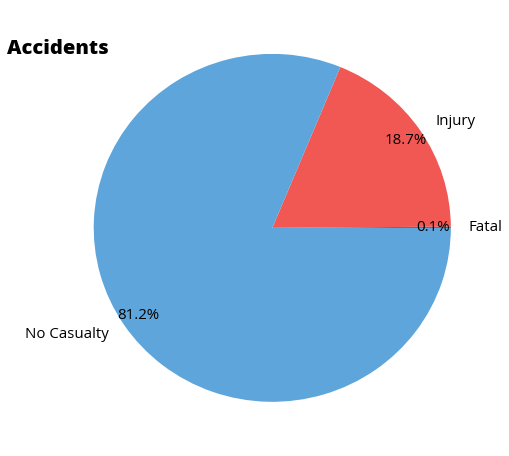

In [18]:
fig, ax = plt.subplots(figsize = (8,8))


labels = 'Fatal', 'Injury', 'No Casualty'
fracs = [N_fatal, N_injury, N_collision - N_fatal - N_injury]

ax.pie(fracs,  labels=labels, autopct='%1.1f%%',pctdistance= 0.9, 
        colors=['#4D4D4D', '#F15854','#5DA5DA' ],textprops = {'fontsize' : 15});

plt.text(-1.2,1,'Accidents',fontsize = 20, ha = 'center', weight = 'bold');
fig.savefig('figures/severity.jpg', transparent=True, bbox_inches='tight')

### Type of Vehicle

What types of vehicle result in more accidents? 
First let us replace nan values with 'unknown' and bring all strings to lowercase.

In [19]:
df_collision['VEHICLE_TYPE_CODE_1'].fillna('unknown',inplace=True)
df_collision['VEHICLE_TYPE_CODE_2'].fillna('unknown',inplace=True)
df_collision['VEHICLE_TYPE_CODE_3'].fillna('unknown',inplace=True)
df_collision['VEHICLE_TYPE_CODE_4'].fillna('unknown',inplace=True)
df_collision['VEHICLE_TYPE_CODE_5'].fillna('unknown',inplace=True)

df_collision['VEHICLE_TYPE_CODE_1'] = df_collision['VEHICLE_TYPE_CODE_1'].str.lower()
df_collision['VEHICLE_TYPE_CODE_2'] = df_collision['VEHICLE_TYPE_CODE_2'].str.lower()
df_collision['VEHICLE_TYPE_CODE_3'] = df_collision['VEHICLE_TYPE_CODE_3'].str.lower()
df_collision['VEHICLE_TYPE_CODE_4'] = df_collision['VEHICLE_TYPE_CODE_4'].str.lower()
df_collision['VEHICLE_TYPE_CODE_5'] = df_collision['VEHICLE_TYPE_CODE_5'].str.lower()

If we look at the values of each of these features, we see that it is quite messy. Let us look at how many different values there are for each feature:

In [20]:
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    print("Number of values for ",feat, " = ",len(df_collision[feat].unique()))

Number of values for  VEHICLE_TYPE_CODE_1  =  148
Number of values for  VEHICLE_TYPE_CODE_2  =  159
Number of values for  VEHICLE_TYPE_CODE_3  =  45
Number of values for  VEHICLE_TYPE_CODE_4  =  35
Number of values for  VEHICLE_TYPE_CODE_5  =  22


For each of these features let us look at the most common values

In [21]:
values_lst = []

for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    values = df_collision.groupby(feat).size().sort_values(ascending = False)
    
    values = values[values > 10000]
    values_lst.append(str(values))
    print("")
    print(values)
                      


VEHICLE_TYPE_CODE_1
passenger vehicle                 621711
sport utility / station wagon     265249
taxi                               42283
unknown                            25708
van                                23212
other                              21250
pick-up truck                      19280
small com veh(4 tires)             12906
large com veh(6 or more tires)     12870
bus                                12369
dtype: int64

VEHICLE_TYPE_CODE_2
passenger vehicle                 467366
unknown                           239127
sport utility / station wagon     201180
taxi                               35111
other                              23219
bicycle                            23167
van                                21390
pick-up truck                      18002
small com veh(4 tires)             14281
large com veh(6 or more tires)     12399
bus                                10219
dtype: int64

VEHICLE_TYPE_CODE_3
unknown                          986810
passenger 

Clearly, we can group all these into categories:
* passenger vehicle
* trucks
* taxis
* motorcycle
* bus
    
Of course, there are also a lot of SUVs type vehicle. However, SUVs are also passenger vehicles, so it might be that some police officer will put SUVs in the 'passenger vehicle' while others will put them in the SUV category. Given that it is not clear how this vehicle code is collected, it is probably safer to group SUV and passenger vehicle in the same category

In [22]:
v1 = set(df_collision['VEHICLE_TYPE_CODE_1'])
v2 = set(df_collision['VEHICLE_TYPE_CODE_2'])
v3 = set(df_collision['VEHICLE_TYPE_CODE_3'])
v4 = set(df_collision['VEHICLE_TYPE_CODE_4'])
v5 = set(df_collision['VEHICLE_TYPE_CODE_5'])

print("Number of distinct values:", len(v1|v2|v3|v4|v5))
babidi = list(v1|v2|v3|v4|v5)

Number of distinct values: 216


#### Clean Up

<b> Bicycle </b>

In [23]:
pat = r'(bike)|(bicycle)|(nyc b)|(pedic)|bik|eb|elect' 
replacement = 'Bike'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    df_collision[feat] = df_collision[feat].apply(lambda x: replacement if re.match(pat,x) else x)

<b> Truck </b>

In [24]:
pat =(r"(box)|(cemen)|(cm)|(co)|(cargo)|(carr)|(delv)|(deliv)|(dump)|(elect)|(fire)|(freig)|(garba)|(ice)|(large)|"
        "(liver)|(p[i]*[c]*k)|(ref)|(tk)|(tow)|(tr)|(tt)|(tank)|(tru)|(trac)|(trail)|(trans)|(trl)|(semi)|(ups t)")
replacement = 'Truck'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    df_collision[feat] = df_collision[feat].apply(lambda x: replacement if re.match(pat,x) else x)

<b> Bus </b>

In [25]:
pat = r'(schoo)|(bu)|(flat)|(fb)|(mta b)|(rv)|(omni)'# probably flat and fb refers to a specific type of bus (flat bus)
replacement = 'Bus'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    df_collision[feat] = df_collision[feat].apply(lambda x: replacement if re.match(pat,x) else x)

<b> Motorcycle </b>

In [26]:
pat = r'(mb)|(moped)|(motor)|(scoot)'
replacement = 'Motorcycle'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    df_collision[feat] = df_collision[feat].apply(lambda x: replacement if re.match(pat,x) else x)

<b> Car </b>

In [27]:
pat = r'(pas)|(p/)|(sedan)|(renta)|(small)|(sub)|(station)|(sport)|(suv)|(util)|(wagon)'
replacement = 'Passenger Vehicle'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    df_collision[feat] = df_collision[feat].apply(lambda x: replacement if re.match(pat,x) else x)

#### Pie Chart

In [28]:
vehicles = ['Bike', 'Truck', 'Motorcycle',  'Passenger Vehicle', 'Bus','taxi']
N_vehicles = []


for v in vehicles:
    N = 0
    for i in range(5):
        feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
        N += (df_collision[feat] == v).sum()
    N_vehicles.append(N)
    
    print('Number of '+v+' = ', N)

N = 0
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    N += (df_collision[feat].apply(lambda x: True if x not in (vehicles + ['unknown']) else False)).sum()
vehicles.append('other')
N_vehicles.append(N)
print("Number of Others", N)

Number of Bike =  30122
Number of Truck =  88152
Number of Motorcycle =  12145
Number of Passenger Vehicle =  1716013
Number of Bus =  25012
Number of taxi =  82234
Number of Others 98268


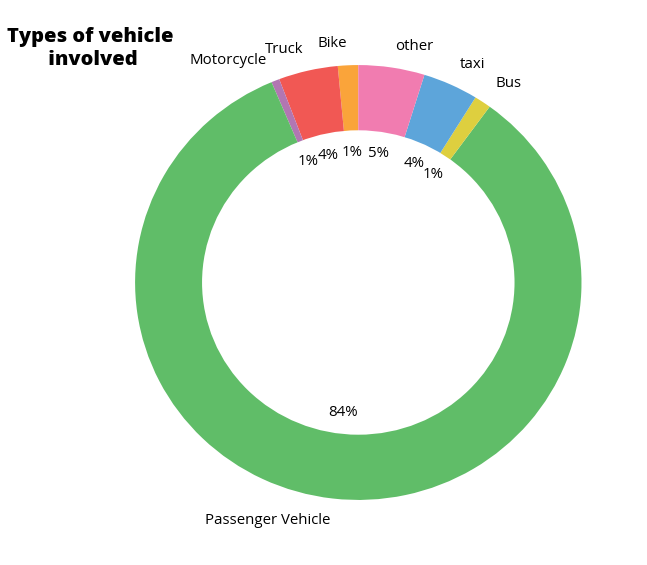

In [29]:
fig1, ax1 = plt.subplots(figsize = (10,10))

explode = np.zeros(len(vehicles))
ax1.pie(N_vehicles,labels=vehicles, autopct='%1.0f%%', explode = explode ,
        colors = ['#FAA43A','#F15854', '#B276B2','#60BD68', '#DECF3F', '#5DA5DA','#F17CB0'],
        startangle=90, textprops = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
#plt.tight_layout()
plt.text(-1.2,1,'Types of vehicle\n involved',fontsize = 20, ha = 'center', weight = 'bold');
#plt.title('Type of vehicles involved',fontsize = 20, ha = 'center',weight = 'bold');
fig.savefig('figures/vehicles.png', transparent=True, bbox_inches='tight')

### Who gets injured? Who gets killed?
Is it a motorist, cyclist or pedsestrian? Let's find out

In [30]:
# count number of motorist, cyclist and pedestrian injured and killer
mot_injured = df_collision['NUMBER_OF_MOTORIST_INJURED'].sum()
cyc_injured = df_collision['NUMBER_OF_CYCLIST_INJURED'].sum()
ped_injured = df_collision['NUMBER_OF_PEDESTRIANS_INJURED'].sum()

mot_killed = df_collision['NUMBER_OF_MOTORIST_KILLED'].sum()
cyc_killed = df_collision['NUMBER_OF_CYCLIST_KILLED'].sum()
ped_killed = df_collision['NUMBER_OF_PEDESTRIANS_KILLED'].sum()

#### Injured

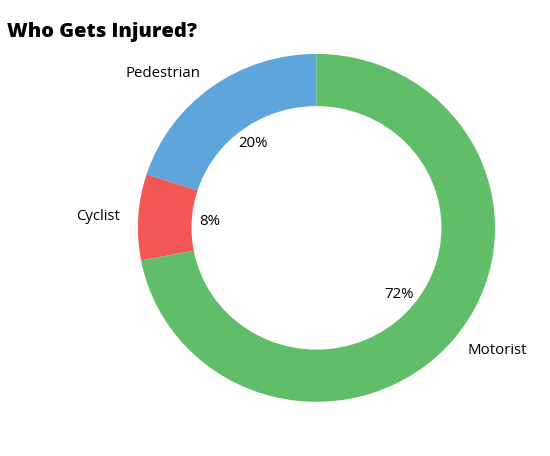

In [31]:
fig1, ax1 = plt.subplots(figsize = (8,8))

who_injured = [ped_injured,cyc_injured,mot_injured]
labels = ['Pedestrian', 'Cyclist', 'Motorist']


ax1.pie(who_injured,labels=labels, autopct='%1.0f%%',
        colors = ['#5DA5DA','#F15854','#60BD68'],
        startangle=90, textprops = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# add text
plt.text(-1.2,1.1,'Who Gets Injured?',fontsize = 20, ha = 'center', weight = 'bold');
fig.savefig('figures/who_injured.png', transparent=True, bbox_inches='tight')

#### Killed

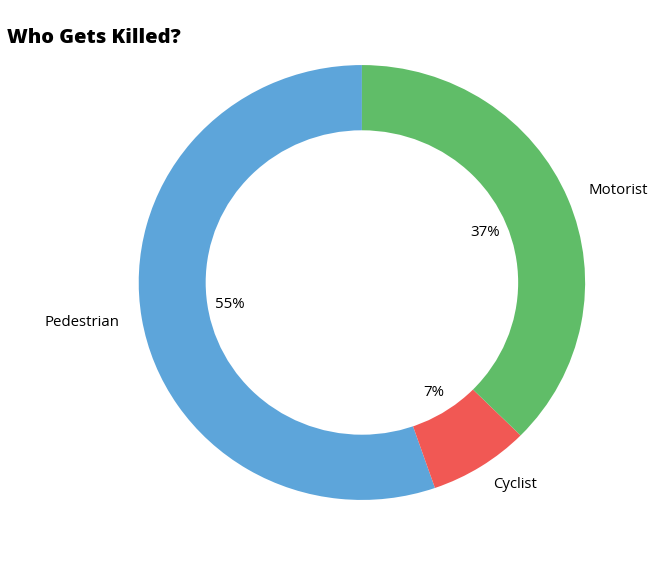

In [32]:
fig1, ax1 = plt.subplots(figsize = (10,10))

who_killed = [ped_killed,cyc_killed,mot_killed]
labels = ['Pedestrian', 'Cyclist', 'Motorist']
ax1.pie(who_killed,labels=labels, autopct='%1.0f%%',
        colors = ['#5DA5DA','#F15854','#60BD68'],
        startangle=90, textprops = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# add text
plt.text(-1.2,1.1,'Who Gets Killed?',fontsize = 20, ha = 'center', weight = 'bold');
#plt.title('Type of vehicles involved',fontsize = 20, ha = 'center',weight = 'bold');
fig.savefig('figures/who_killed.png', transparent=True, bbox_inches='tight')

## Where ?

Let us now map accidents in NYC. We will also plot the traffic as evaluated in the years 2012-2013

### Mapping Accidents in NYC

In [33]:
# border of the map
lng_min, lng_max = -74.3 , -73.65
lat_min, lat_max = 40.48 , 40.92

#### Estimating Traffic Volume

The problem with the volume traffic device is that they are unequally distributed: there are many more in Manhattan than in other boroughs of NYC. Unfortunately, this is the only measure of traffic that I have. To estimate the (average daily) traffic in a given region, I will use a simple KNN regressor.

In [34]:
from sklearn import neighbors

X = df_DAVC[['LONGITUDE','LATITUDE']]
y = df_DAVC['TOTAL_DAY']

# the traffic is measured using the 3 closer counter devices and the result is weighted by distance
clf = neighbors.KNeighborsRegressor(n_neighbors = 5, weights='distance')
clf.fit(X, y)

# create a grid of points on the map and predict the outcome
lngs, lats = np.meshgrid(np.arange(lng_min, lng_max, 0.0005),
                     np.arange(lat_min, lat_max, 0.0005))
traffic_map = clf.predict(np.c_[lngs.ravel(), lats.ravel()])
traffic_map = traffic_map.reshape(lngs.shape)

Given that the traffic data are mainly in 2013, let us consider traffic accidents in the year 2013 only:

In [35]:
df_collision_13 = df_collision[df_collision['DATE'].apply(lambda x: x.year == 2013)]

#### Map

In [ ]:
fig, ax  = plt.subplots(figsize=(22, 22))

## CREATE A MAP OF NYC
#######################

# this is to make sure that the map is computed just once (since it is time consuming)
try:
    m_nyc
except NameError:
    m_nyc = Basemap(projection='merc',llcrnrlat=lat_min,urcrnrlat=lat_max,
                    llcrnrlon= lng_min,urcrnrlon=lng_max,resolution='f')

# Set axis limit
x_min, y_min = m_nyc(lng_min,lat_min) 
x_max, y_max = m_nyc(lng_max,lat_max)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Draw the coastline and fill the map with color (blue)
m_nyc.drawcoastlines()
m_nyc.drawrivers(color = '#DBDBDB')
m_nyc.drawmapboundary(fill_color = '#DBDBDB')

## CREATE A PATCH OF CONTINENTS
################################

map_edges = np.array([[x_min,y_min],[x_max,y_min],[x_max,y_max],[x_min,y_max]])
polys = [p.boundary for p in m_nyc.landpolygons]

polys = [map_edges]+polys[:] # polygons of the map + edges

## creating the patch from polys (see https://matplotlib.org/users/path_tutorial.html)
codes = [
    [patches.Path.MOVETO] + [patches.Path.LINETO for p in p[1:]]
        for p in polys
]

polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]

path = patches.Path(polys_lin, codes_lin)
patch_ocean = patches.PathPatch(path,facecolor='#71BEE5', lw=1)

# add ocean patch
ax.add_patch(patch_ocean)


## CREATE A PATCH OF NYC
########################

# get NYC boundary polygon
from NYC_boundaries import *
NYC_boundary = get_boundary() 

x_bm, y_bm = m_nyc(NYC_boundary[:,0],NYC_boundary[:,1])
NYC_boundary_bm = np.vstack((x_bm,y_bm)).transpose()
patch_NYC = patches.Polygon(NYC_boundary_bm, facecolor='none',edgecolor = 'black',lw=1)
ax.add_patch(patch_NYC)

## TRAFFIC MAP
##############
lngs_bm, lats_bm = m_nyc(lngs,lats)
traffic = ax.pcolormesh(lngs_bm, lats_bm, traffic_map, vmax = 30000, cmap='YlGnBu',clip_path=patch_NYC,clip_on=True)


## COLLISION MAP
################
x_bm, y_bm = m_nyc(np.array(df_collision_13['LONGITUDE']),np.array(df_collision_13['LATITUDE']))
ax.scatter(x_bm,y_bm, 
           c = '#F15854', alpha = 0.05, marker = ',', s = 3, 
           label = "Motor Vehicle Collision",clip_path=patch_NYC,clip_on=True)

## TRAFFIC COUNT DEVICE
########################

x_bm, y_bm = m_nyc(np.array(df_DAVC['LONGITUDE']),np.array(df_DAVC['LATITUDE']))
ax.scatter(x_bm , y_bm , 
           c = 'black', 
           alpha = 1, marker = 'o', s = 30, 
           label = "Traffic Count Device",clip_path=patch_NYC,clip_on=True)

## CLEAN UP PLOT
################

# Remove axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

# legend
lgd = plt.legend(fontsize = 25, framealpha=0,loc="upper left",bbox_to_anchor=(0.014, 0.85))
for l in lgd.legendHandles:
    l._sizes = [500] # change size of the marker in legend
    l.set_alpha(1) # change alpha of the marker in legend

lgd.get_frame().set_linewidth(0.0)

# traffic count color bar
cbar = fig.colorbar(traffic, orientation = 'vertical', shrink = 0.5, pad = -1.05)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.set_ylabel('\nAverage Daily Traffic Count',fontsize = 25,rotation = 90)
cbar.ax.yaxis.set_label_coords(-2,0.6)
cbar.ax.tick_params(labelsize=15) 


# title
dx = x_max-x_min
dy = y_max-y_min
ax.text(x_min+0.25*dx,y_min+0.90*dy,'Motor Vehicle Collisions\n in NYC (2013)', fontsize = 35, ha = "center", weight = 'bold');
fig.savefig('figures/NYC_MVC_map.png', transparent=False, bbox_inches='tight')

### Accidents per Borough
Let us look at accidents per borough and compare it with the traffic

In [ ]:
# proportion of accidents per borough
prop_borough = df_collision.groupby('BOROUGH').size()/(~df_collision['BOROUGH'].isnull()).sum()
prop_injury_borough = df_injury.groupby('BOROUGH').size()/N_injury
prop_fatal_borough = df_fatal.groupby('BOROUGH').size()/N_fatal

# organise index by alphabetical order
prop_borough.sort_index(inplace=True)
prop_injury_borough.sort_index(inplace=True)
prop_fatal_borough.sort_index(inplace=True)

In [ ]:
# proportion of traffic per borough
traffic_borough = df_DAVC.groupby('BOROUGH').agg({'TOTAL_DAY':np.mean})
traffic_borough = traffic_borough/traffic_borough.sum()

# organise index by alphabetical order
traffic_borough.sort_index(inplace=True)
traffic_borough

Let us also compute the standard deviation on the estimated proportion (assuming a multinomial distribution)


In [ ]:
std_prop_borough = prop_borough.apply(lambda x: (x*(1-x)/N_collision)**0.5)
std_prop_injury_borough = prop_injury_borough.apply(lambda x: (x*(1-x)/N_injury)**0.5)
std_prop_fatal_borough = prop_fatal_borough.apply(lambda x: (x*(1-x)/N_fatal)**0.5)

Finally, let us plot the result:

In [ ]:
fig = plt.figure(figsize=(11, 7))

x_borough = np.arange(1,len(prop_borough.index)+1)

# Total
plt.bar(x_borough-0.3, height = prop_borough*100, width = 0.3,
        label = 'Total',color = 'darkorange', 
        yerr = std_prop_borough*100, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# Injured only
plt.bar(x_borough, height = prop_injury_borough*100, width = 0.3, 
         label = 'Injuries',color = 'orange',
       yerr = std_prop_injury_borough*100 , error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# At least one fatality
plt.bar(x_borough+0.3, height = prop_fatal_borough*100, width = 0.3, 
        label = 'Fatalities', color = 'navajowhite',
       yerr = std_prop_fatal_borough*100, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# Traffic
plt.plot(x_borough, traffic_borough*100, marker = 'o',
        label = 'Estimated Traffic (%)', color = 'gray');


# graph
plt.xlabel('Borough', fontsize = 15)
plt.xticks(x_borough,prop_borough.index)
plt.xlim(0.4,6)
plt.ylim(0,40)
plt.legend()

plt.title('Proportion of accidents per borough',fontsize = 15);

This result should be taken with a grain of salt for at least two reasons.  

1) The first one is that many locations are missing in our dataset, which begs the question: are those missing location equally distributed or do they affect more locations than others? 

2) The second reason is that our way of estimating traffic count in one particular borough is not very good. In particular, if traffic count are unequally distributed (as they are), a borough with very few traffic count device may look as though there is no traffic and a borough with many traffic count device may look as though there is a huge amount of traffic. 

## When ?

When do accidents happen? At night or during the day? On which months? On which days?

### Hour of the day

Let us extract the hour and count the proportion of accidents for each hour:

In [ ]:
df_collision['HOUR'] = df_collision['TIME'].apply(lambda x: x.hour)
df_injury['HOUR'] = df_injury['TIME'].apply(lambda x: x.hour)
df_fatal['HOUR'] = df_fatal['TIME'].apply(lambda x: x.hour)

prop_hour = df_collision.groupby('HOUR').size()/N_collision
prop_injury_hour = df_injury.groupby('HOUR').size()/N_injury
prop_fatal_hour = df_fatal.groupby('HOUR').size()/N_fatal

Let us also compute the standard deviation on the estimated proportion (assuming a multinomial distribution)

In [ ]:
std_prop_hour = prop_hour.apply(lambda x: (x*(1-x)/N_collision)**0.5)
std_prop_injury_hour = prop_injury_hour.apply(lambda x: (x*(1-x)/N_injury)**0.5)
std_prop_fatal_hour = prop_fatal_hour.apply(lambda x: (x*(1-x)/N_fatal)**0.5)

We then plot these proportions and consider  
    (1) the whole data set,   
    (2) those with injuries,  
    (3) those with fatalities.  
The result is also compared with the traffic per hour

In [ ]:
fig = plt.figure(figsize=(11, 7))


x_hours = np.arange(1,25)




# Total
plt.bar(x_hours-0.3, height = prop_hour*100, width = 0.3,
        label = 'Total',color = 'darkorange', 
        yerr = std_prop_hour*100, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# Injured only
plt.bar(x_hours, height = prop_injury_hour*100, width = 0.3, 
         label = 'Injuries',color = 'orange',
       yerr = std_prop_injury_hour*100 , error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# At least one fatality
plt.bar(x_hours+0.3, height = prop_fatal_hour*100, width = 0.3, 
        label = 'Fatalities', color = 'navajowhite',
       yerr = std_prop_fatal_hour*100, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# Traffic
hours = df_traffic.columns[df_traffic.columns.str.match(r'[\d]+-[\d]+')]
traffic_hours = 100*df_traffic[hours].sum()/df_traffic[hours].sum().sum()
plt.plot(x_hours, traffic_hours,'-o',
        label = 'Average Traffic in NYC (2012-2013)',color = 'gray');

# graph
plt.xlabel('hour of the day', fontsize = 15)
plt.xticks(np.arange(1,25,1),df_traffic[hours].columns,rotation = 90)
plt.xlim(0.4,24.6)
plt.ylim(0,8)
plt.legend()

plt.title('Percentage of accidents per hour of day',fontsize = 15);
fig.savefig('figures/time_hour.png', transparent=True, bbox_inches='tight')

First let us notice that the total number of accidents is correlated with traffic (as expected). However the total number of deadly accidents seems uncorrelated with traffic volume. 
We can be a bit more quantitative and look at the Pearson correlation function (along with the corresponding p-value)

In [ ]:
from scipy.stats import pearsonr

print('----------')
print('Traffic and Total Accidents')
res = pearsonr(traffic_hours,prop_hour)
print('Correlation coefficient = ', res[0])
print('p-value = ', res[1])

print('----------')
print('Traffic and Accidents with Injuries')
res = pearsonr(traffic_hours,prop_injury_hour)
print('Correlation coefficient', res[0])
print('p-value = ', res[1])

print('----------')
print('Traffic and Fatal Accidents')
res = pearsonr(traffic_hours,prop_fatal_hour)
print('Correlation coefficient', res[0])
print('p-value = ', res[1])



Clearly, the number of fatal accidents does not correlate with the amount of traffic (odd!!!)

### Day of the week
We then extract the corresponding weekday and count the proportion of accidents for each hour:

In [ ]:
df_collision['WEEKDAY'] = df_collision['DATE'].apply(lambda x: x.weekday())
df_injury['WEEKDAY'] = df_injury['DATE'].apply(lambda x: x.weekday())
df_fatal['WEEKDAY'] = df_fatal['DATE'].apply(lambda x: x.weekday())

prop_week = df_collision.groupby('WEEKDAY').size()/N_collision
prop_injury_week = df_injury.groupby('WEEKDAY').size()/N_injury
prop_fatal_week = df_fatal.groupby('WEEKDAY').size()/N_fatal

Let us also compute the standard deviation on the estimated proportion (assuming a multinomial distribution)

In [ ]:
std_prop_week = prop_week.apply(lambda x: (x*(1-x)/N_collision)**0.5)
std_prop_injury_week = prop_injury_week.apply(lambda x: (x*(1-x)/N_injury)**0.5)
std_prop_fatal_week = prop_fatal_week.apply(lambda x: (x*(1-x)/N_fatal)**0.5)

In [ ]:
fig = plt.figure(figsize=(15, 10))
# Total
plt.bar(prop_week.index-0.3, height = prop_week*100, width = 0.3,
        label = 'Total',color = 'darkorange', 
        yerr = std_prop_week*100, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# Injured only
plt.bar(prop_injury_week.index, height = prop_injury_week*100, width = 0.3, 
         label = 'Injuries',color = 'orange',
       yerr = std_prop_injury_week*100 , error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# At least one fatality
plt.bar(prop_fatal_week.index+0.3, height = prop_fatal_week*100, width = 0.3, 
        label = 'Fatalities', color = 'navajowhite',
       yerr = std_prop_fatal_week*100, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# graph
#plt.xlabel('day of the week', fontsize = 15)
plt.xticks(np.arange(0,7,1),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlim(-0.6,7)
plt.ylim(0,25)
plt.legend()

plt.title('Percentage of accidents per day of week',fontsize = 15);
fig.savefig('figures/time_week.png', transparent=True, bbox_inches='tight')

There is not much difference between the day of the week. One interesting thing though is that while accidents with no fatality are slightly less frequent on weekends, fatal ones seem to increase (slightly) on weekends.

### Month of the year


We then extract the corresponding weekday and count the proportion of accidents for each hour:

In [ ]:
df_collision['MONTH'] = df_collision['DATE'].apply(lambda x: x.month)
df_injury['MONTH'] = df_injury['DATE'].apply(lambda x: x.month)
df_fatal['MONTH'] = df_fatal['DATE'].apply(lambda x: x.month)

prop_month = df_collision.groupby('MONTH').size()/N_collision
prop_injury_month = df_injury.groupby('MONTH').size()/N_injury
prop_fatal_month = df_fatal.groupby('MONTH').size()/N_fatal

Let us also compute the standard deviation on the estimated proportion (assuming a multinomial distribution)

In [ ]:
std_prop_month = prop_month.apply(lambda x: (x*(1-x)/N_collision)**0.5)
std_prop_injury_month = prop_injury_month.apply(lambda x: (x*(1-x)/N_injury)**0.5)
std_prop_fatal_month = prop_fatal_month.apply(lambda x: (x*(1-x)/N_fatal)**0.5)

In [ ]:
fig = plt.figure(figsize=(15, 10))
# Total
plt.bar(prop_month.index-0.3, height = prop_month*100, width = 0.3,
        label = 'Total',color = 'darkorange', 
        yerr = std_prop_month*100, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# Injured only
plt.bar(prop_injury_month.index, height = prop_injury_month*100, width = 0.3, 
         label = 'Injuries',color = 'orange',
       yerr = std_prop_injury_month*100 , error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# At least one fatality
plt.bar(prop_fatal_month.index+0.3, height = prop_fatal_month*100, width = 0.3, 
        label = 'Fatalities', color = 'navajowhite',
       yerr = std_prop_fatal_month*100, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1));

# graph
#plt.xlabel('day of the week', fontsize = 15)
plt.xticks(np.arange(1,13,1),['January','February','March','April','May','June',
                              'July', 'August', 'September', 'October', 'November', 'December'])
plt.xlim(0.4,12.6)
plt.ylim(0,13)
plt.legend()

plt.title('Percentage of accidents per month of year',fontsize = 15);
fig.savefig('figures/time_month.png', transparent=True, bbox_inches='tight')

### Day of the year


We then extract the corresponding weekday and count the proportion of accidents for each hour:

In [ ]:
df_collision['DAY_OF_YEAR'] = df_collision['DATE'].dt.strftime('%m-%d')
df_injury['DAY_OF_YEAR'] = df_injury['DATE'].dt.strftime('%m-%d')
df_fatal['DAY_OF_YEAR'] = df_fatal['DATE'].dt.strftime('%m-%d')

In [ ]:
df_collision = df_collision[df_collision['DAY_OF_YEAR']!= '02-29']
df_injury = df_injury[df_injury['DAY_OF_YEAR']!= '02-29']
df_fatal = df_fatal[df_fatal['DAY_OF_YEAR']!= '02-29']

df_collision['DAY_OF_YEAR'] = pd.to_datetime(df_collision['DAY_OF_YEAR'], format='%m-%d')
df_injury['DAY_OF_YEAR'] = pd.to_datetime(df_injury['DAY_OF_YEAR'], format='%m-%d')
df_fatal['DAY_OF_YEAR'] = pd.to_datetime(df_fatal['DAY_OF_YEAR'], format='%m-%d')

In [ ]:
prop_date = df_collision.groupby('DAY_OF_YEAR').size()/N_collision
prop_injury_date = df_injury.groupby('DAY_OF_YEAR').size()/N_injury
prop_fatal_date = df_fatal.groupby('DAY_OF_YEAR').size()/N_fatal

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(prop_date.index.date,prop_date)

months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
monthsFmt = mdates.DateFormatter('%b')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(monthsFmt)

plt.title('Percentage of accidents per day of year',fontsize = 15);

Interestingly, we see three troughs on main holidays: January 1st, July 4th and December 25th.

#### Zooming On December

In [ ]:
prop_december = prop_date[prop_date.index.month == 12]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(prop_december.index.date,prop_december)
days = mdates.DayLocator()
monthsFmt = mdates.DateFormatter('%d')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(monthsFmt)

plt.title('Percentage of accidents in December',fontsize = 15);

There is a clear trough on Christmas day

#### Zooming On July

In [ ]:
prop_july = prop_date[prop_date.index.month == 7]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(prop_july.index.date,prop_july)
days = mdates.DayLocator()
monthsFmt = mdates.DateFormatter('%d')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(monthsFmt)

plt.title('Percentage of accidents in July',fontsize = 15);

There is a clear trough on July 4th

#### Zooming On January

In [ ]:
prop_january = prop_date[prop_date.index.month == 1]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(prop_january.index.date,prop_january)
days = mdates.DayLocator()
monthsFmt = mdates.DateFormatter('%d')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(monthsFmt)

plt.title('Percentage of accidents in January',fontsize = 15);

There is a clear trough on January 1st

## Why ?

In [ ]:
CF = ['CONTRIBUTING_FACTOR_VEHICLE_1',
      'CONTRIBUTING_FACTOR_VEHICLE_2',
      'CONTRIBUTING_FACTOR_VEHICLE_3',
      'CONTRIBUTING_FACTOR_VEHICLE_4',
      'CONTRIBUTING_FACTOR_VEHICLE_5']

In [ ]:
all_causes = list(df_collision[CF].fillna('').unstack().unique())
all_causes.remove('')
all_causes.remove('Unspecified')

In [ ]:
def extract_causes(filter_ = None):
    if filter_ is not None:
        df = df_collision[filter_] # data frame with filter applied
    else:
        df = df_collision[:]
    
    Ncauses = len(df)*5 - df[CF].isnull().unstack().sum()
    for cf in CF:
        
        causes_v = df.groupby(cf).size()/Ncauses
        causes_v = causes_v.add(pd.Series(np.zeros(len(all_causes)),index = all_causes),fill_value = 0)
        
        try:
            prop_causes = prop_causes + causes_v
        except:
            prop_causes = causes_v
        
    return prop_causes[all_causes]

### Distinguishing between injured/fatal

In [ ]:
prop_causes = extract_causes()
prop_causes.sort_values(ascending=False,inplace=True)

prop_injury_causes = extract_causes(df_collision['NUMBER_OF_PERSONS_INJURED'] > 0)
prop_injury_causes = prop_injury_causes[prop_causes.index]

prop_fatal_causes = extract_causes(df_collision['NUMBER_OF_PERSONS_KILLED'] > 0)
prop_fatal_causes = prop_fatal_causes[prop_causes.index]

In [ ]:
# std_prop_causes = prop_causes.apply(lambda x: (x*(1-x)/N_collision)**0.5)
# std_prop_injury_causes = prop_injury_causes.apply(lambda x: (x*(1-x)/N_injury)**0.5)
# std_prop_fatal_causes = prop_fatal_causes.apply(lambda x: (x*(1-x)/N_fatal)**0.5)

In [ ]:
fig = plt.figure(figsize=(15, 10))


x_causes = np.arange(1,len(all_causes)+1)

plt.bar(x_causes-0.3, height = prop_causes*100, width = 0.3,
        label = 'Total',color = 'darkorange')
 
#         yerr = std_prop_causes*100, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1));

# Injured only
plt.bar(x_causes, height = prop_injury_causes*100, width = 0.3, 
         label = 'Injuries',color = 'orange')
#        yerr = std_prop_injury_causes*100, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1));

# At least one fatality
plt.bar(x_causes+0.3, height = prop_fatal_causes*100, width = 0.3, 
        label = 'Fatalities', color = 'navajowhite')
#        yerr = np.array(std_prop_fatal_causes)*100, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1));

plt.legend()

plt.xticks(x_causes, prop_causes.index,rotation = 90);
plt.title('Percentage of accidents per cause',fontsize = 15);
fig.savefig('figures/causes.png', transparent=True, bbox_inches='tight')

We can extract the main causes of accidents

   1) Driver inattention  <br>
   2) Failing to give the right-of-way

In addition, we can see that there are additional causes when looking at fatal accidents:
 
   1) Traffic control disregarded <br>
   2) Unsage speed <br>
   3) Passenger distration <br>
   4) Alcohol <br>

### Distinguishing between Day and Night

In [ ]:
begin_night = datetime.datetime.strptime('22:00','%H:%M').time()
end_night = datetime.datetime.strptime('5:00','%H:%M').time()

In [ ]:
night_filter = ((df_collision['TIME'] < end_night) | (df_collision['TIME'] > begin_night))

In [ ]:
prop_night_causes = extract_causes(night_filter)
prop_night_causes.sort_values(ascending=False,inplace=True)

prop_day_causes = extract_causes(~night_filter)
prop_day_causes = prop_day_causes[prop_night_causes.index]

In [ ]:
fig = plt.figure(figsize=(15, 10))


x_causes = np.arange(1,len(all_causes)+1)

plt.bar(x_causes-0.2, height = prop_night_causes*100, width = 0.4,
        label = 'Night',color = 'darkorange')
 
#         yerr = std_prop_causes*100, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1));

# Injured only
plt.bar(x_causes+0.2, height = prop_day_causes*100, width = 0.4, 
         label = 'Day',color = 'navajowhite')
#        yerr = std_prop_injury_causes*100, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1));


plt.legend()

plt.xticks(x_causes, prop_night_causes.index,rotation = 90);
plt.title('Percentage of accidents per cause',fontsize = 15);
fig.savefig('figures/causes_nightday.png', transparent=True, bbox_inches='tight')